# MOM adaptation of the LASSO

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import matplotlib.pyplot as plt
from momAPI.procedure.procedure_MOM import * 
from momAPI.procedure.random_data import *
from momAPI.Linear_models.MOM_LASSO import mom_lasso
from momAPI.Cross_validation.MOM_CV import cross_validation_V_fold

In [3]:
plt.style.use("seaborn-darkgrid")

In [20]:
iter_max = 200
n = 200
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1 / np.sqrt(50)
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1,X1  =  data1(n , t_0 , 1)
Y2,X2  =  data2(n_outliers , features , type_outliers  =  2)
Y,X  =  data_merge(Y1, X1, Y2, X2)

Text(0.5, 0, 'Features number')

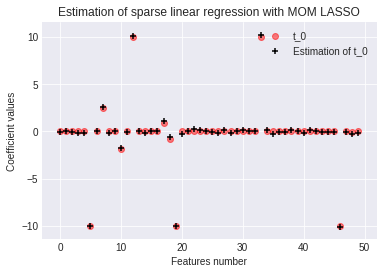

In [21]:
%matplotlib inline
model = mom_lasso(9 , lamb = 0.1 , iter_max = 200)
model.fit(X , Y  , step_size = 0.0001 , initialize = "random")
model.coefs()

plt.scatter(np.arange(50) , t_0  , color = "r" , label = "t_0" , alpha = 0.5 )
plt.scatter(np.arange(50) , model.coefs() , label = "Estimation of t_0" , color = 'black' , marker = "+")

plt.legend()
plt.title("Estimation of sparse linear regression with MOM LASSO")
plt.ylabel("Coefficient values")
plt.xlabel("Features number")

In [27]:
outliers = []
for i in range(len(Y)):
    
    if i not in model.hist :
        outliers.append(i)

In [28]:
Y[outliers]

array([ 1.00000000e+04, -4.11911174e+00,  1.00000000e+04,  1.00000000e+04])

(array([ 3.,  7.,  4., 10.,  7.,  4.,  8.,  7.,  8.,  3.,  8.,  3.,  3.,
         7.,  3.,  0.,  9.,  5.,  9.,  8.,  6.,  3.,  3., 10.,  4.,  2.,
         1.,  6.,  5.,  4.,  3.,  2.,  6.,  4.,  9.,  7.,  4.,  5.,  8.,
         6., 13.,  6.,  1., 10.,  3.,  8.,  4.,  3.,  5.,  7.,  6.,  5.,
         3.,  4.,  7.,  3.,  4.,  5.,  5.,  4.,  4.,  6.,  2.,  4.,  3.,
         5.,  9.,  3.,  2.,  7.,  5.,  5., 11.,  3.,  8.,  5.,  3.,  2.,
         5.,  0.,  3.,  7.,  4.,  5., 10.,  1.,  6.,  5.,  7.,  9.,  2.,
         4.,  6.,  5.,  4.,  3.,  7.,  6.,  9.,  6.,  6.,  7.,  1.,  6.,
         4., 12.,  3.,  5.,  7.,  5.,  6.,  8.,  6.,  1.,  6.,  8.,  3.,
         5.,  2.,  5.,  6.,  7.,  4.,  7.,  3.,  5.,  9.,  5.,  4.,  5.,
         5.,  5.,  7., 10.,  4.,  7.,  7.,  6.,  2.,  6.,  5., 11.,  5.,
         9.,  4.,  8.,  5.,  5.,  5.,  8.,  5.,  6.,  3.,  4.,  3.,  6.,
         8.,  8.,  6.,  3.,  5.,  3.,  5.,  6.,  7.,  2.,  7.,  8.,  7.,
         7.,  6.,  0.,  3.,  3.,  6.,  4.,  7., 11.

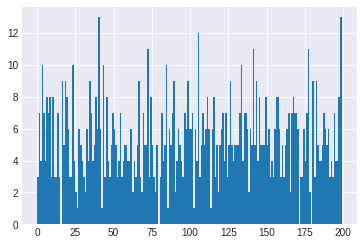

In [33]:
%matplotlib inline
plt.hist(model.hist , bins = np.arange(200))

### Adaptive choice of K

In [34]:
def best_K(X , Y , mini , maxi , step):
    
    t1 = time.time()
    _ , p = np.shape(X)
    lamb = 1/ np.sqrt(p)
    score = []
    
    for K in range(mini , maxi , step):
        
        model = mom_lasso(K)
        score_step = cross_validation_V_fold(model , X , Y , 5 , K , random = True)
        score.append(np.mean(score_step))
        
    t2 = time.time()
    print("Time :",(t2-t1) * 10000 // 1 / 10000,"sec")
    return  mini + np.argmin(score) * step 

In [35]:
iter_max = 200
n = 2000
n_outliers = 3
features  =  50
sparsity  =  10
lamb  =  1
K1  =  5
K2  =  7
step_size1  =  0.01
step_size2  =  0.003
sigma  =  1
t_0  =  create_t_0(features,sparsity)
Y1,X1  =  data1(n,t_0,1)
Y2,X2  =  data2(n_outliers , features , type_outliers  =  2)

Y,X  =  data_merge(Y1, X1, Y2, X2)

best_K(X , Y , 1 , 80 , 5 )

Time : 25.3728 sec


16

### Test of the robustness

In [99]:
import numpy.linalg
import progressbar
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [45]:
from sklearn.linear_model import Lasso

One outliers

In [112]:
n = 1000
sparsity  =  10
features  =  50
lamb  =  1 / np.sqrt(50)
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1 , X1  =  data1(n , t_0 , sigma)
X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
score_MOM = []
score_classic = []
bar = progressbar.progressbar

for n_outliers in bar(range(1 , 100 , 10)) : 
    
    X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
    
    #Data train corruption
    if n_outliers != 0 : 
        Y2 , X2  =  data2(n_outliers , features , type_outliers  =  1)
        Y_train , X_train = data_merge(Y_train , X_train , Y2 , X2)
    
    #Robust model training and evaluation
    model = mom_lasso(62 , lamb = lamb)
    model.fit(X_train, Y_train)
    score_step = mean_squared_error(model.predict(X_test),Y_test)
    score_MOM.append(np.mean(score_step))
    
    #Sklearn model training and evalutation
    model_2 = Lasso()
    model_2.fit(X_train, Y_train)
    score_step_class = mean_squared_error(model_2.predict(X_test),Y_test)
    score_classic.append(np.mean(score_step_class))

100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


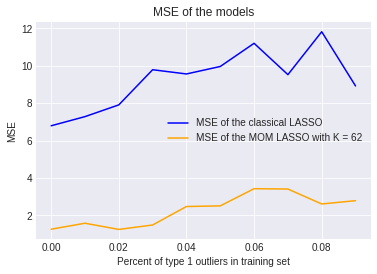

In [113]:
%matplotlib inline
l = [(i * 10 )/1000 for i in range(10)]

plt.plot(l , score_classic , color ='blue' , label = "MSE of the classical LASSO")
plt.plot(l , score_MOM , color ='orange' , label = "MSE of the MOM LASSO with K = 62")
plt.xlabel("Percent of type 1 outliers in training set")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the models")
#plt.yscale('log')
plt.savefig('lasso_type_1.png')

In [104]:
n = 1000
sparsity  =  10
features  =  50
lamb  =  1 / np.sqrt(50)
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1 , X1  =  data1(n , t_0 , sigma)
X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
score_MOM = []
score_classic = []
bar = progressbar.progressbar

for n_outliers in bar(range(1 , 50 , 5)) : 
    X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
    #Data train corruption
    if n_outliers != 0 : 
        Y2 , X2  =  data2(n_outliers , features , type_outliers  =  2)
        Y_train , X_train = data_merge(Y_train , X_train , Y2 , X2)
    
    #Robust model training and evaluation
    model = mom_lasso(62 , lamb = lamb)
    model.fit(X_train, Y_train)
    score_step = mean_squared_error(model.predict(X_test),Y_test)
    score_MOM.append(np.mean(score_step))
    
    #Sklearn model training and evalutation
    model_2 = Lasso()
    model_2.fit(X_train, Y_train)
    score_step_class = mean_squared_error(model_2.predict(X_test),Y_test)
    score_classic.append(np.mean(score_step_class))

100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


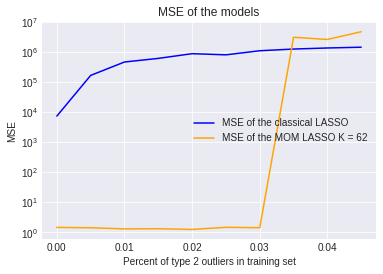

In [105]:
%matplotlib inline

l = [(i * 5 )/1000 for i in range(10)]

plt.plot(l , score_classic , color ='blue' , label = "MSE of the classical LASSO")
plt.plot(l , score_MOM , color ='orange' , label = "MSE of the MOM LASSO K = 62")
plt.xlabel("Percent of type 2 outliers in training set")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the models")
plt.yscale('log')
plt.savefig('lasso_type_2.png')

Heavy tail

In [87]:
n = 1000
sparsity  =  10
features  =  50
lamb  =  1 / np.sqrt(50)
sigma  =  1
t_0  =  create_t_0(features , sparsity)
Y1 , X1  =  data1(n , t_0 , sigma)
X_train , X_test , Y_train , Y_test = train_test_split(X1 , Y1)
score_MOM = []
score_classic = []
bar = progressbar.progressbar

for n_outliers in bar(range(1 , 50 , 5)) : 
    
    #Data train corruption
    if n_outliers != 0 : 
        Y2 , X2  =  data3(n_outliers , t_0)
        Y_train , X_train = data_merge(Y_train , X_train , Y2 , X2)
    
    #Robust model training and evaluation
    model = mom_lasso(62 , lamb = lamb)
    model.fit(X_train, Y_train)
    score_step = np.sum(np.square(model.predict(X_test)-Y_test))
    score_MOM.append(np.mean(score_step))
    
    #Sklearn model training and evalutation
    model_2 = Lasso()
    model_2.fit(X_train, Y_train)
    score_step_class = np.sum(np.square(model_2.predict(X_test)-Y_test))
    score_classic.append(np.mean(score_step_class))

100% (10 of 10) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


Text(0.5, 1.0, 'MSE of the model')

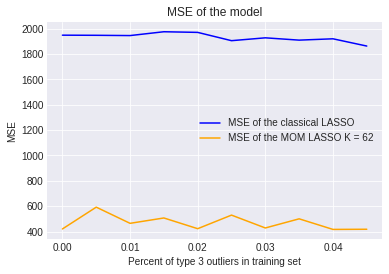

In [89]:
%matplotlib inline

l = [(i * 5 )/1000 for i in range(10)]

plt.plot(l , score_classic , color ='blue' , label = "MSE of the classical LASSO")
plt.plot(l , score_MOM , color ='orange' , label = "MSE of the MOM LASSO K = 62")
plt.xlabel("Percent of type 3 outliers in training set")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE of the model")

Source : [1] Regression shrinkage and selection via the lasso, Robert Tibshirani, 1996